In [3]:
#Required Libraries
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score
import pickle
import random
import re
import nltk.stem
from nltk.stem import SnowballStemmer 
from nltk import stem
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve,auc
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.ensemble import RandomForestClassifier

In [2]:
#Importing the dataset
p = 0.25  # 25% of the lines
Corpus = pd.read_csv('train.csv',names=['Class','Title','Content'],skiprows=lambda i: i>0 and random.random() > p)

# Data Exploration

In [3]:
#Data Exploration
cp =Corpus.groupby('Class')
cp.size()

Class
1      9978
2     10055
3     10117
4      9972
5      9958
6      9880
7      9918
8     10030
9     10116
10    10082
11     9925
12    10010
13     9943
14     9951
dtype: int64

<h4>So from the above table we came to know that data set is almost equally divided(Balanced)</h4>
<h4>We are telling the above statement by seeing there are equal number of data points in all the classes</h4>

In [4]:
Corpus['Content']

0          Abbott of Farnham E D Abbott Limited was a Br...
1          Marvell Software Solutions Israel known as RA...
2          The de Wendel Family is an industrialist fami...
3          Witcomb Cycles formerly known as Witcomb Ligh...
4          Goldilocks Bakeshop is a bakeshop chain based...
                                ...                        
139930     Aruvu Rezuru: Kikaijikake no Yōseitachi (アルヴ・...
139931     A Dictionary of Modern English Usage (1926) b...
139932     If I Forget Thee O Earth is a short story wri...
139933     Endocrine Research is a peer-reviewed medical...
139934     Mademoiselle was a women's magazine first pub...
Name: Content, Length: 139935, dtype: object

<h3>Observations:</h3>
<h4>There are 139716 data points in our dataset.Dataset is large enough though we took a sample of DBPedia dataset to generalize the behaviour</h4>
<h4>Dataset is not processed, which means Content is containing alpha numeric values and also different languages like Japanese,Hebrew etc</h4>
<h4>So dataset needs to be processed for further proceedings of buiding models and classification etc</h4>

In [5]:
Corpus['Content'].describe()

count                                                139935
unique                                               139923
top        Tom Clancy's Net Force Explorers or Net Force...
freq                                                      5
Name: Content, dtype: object

<h4>There are 139716 pages and 139705 pages are unique. It means that for 11 pages Content is same but it differs with title</h4>

# Pre Processing steps

In [6]:
Corpus.isnull().values.any()

False

<h4>The primary pre processing step is to find missing values in the dataset and to replace them</h4>
<h4>In our data set there are no missing values</h4>

<h3>Changing the case to lower</h3>

In [7]:
Corpus['Content'] = [entry.lower() for entry in Corpus['Content']]
Corpus['Title'] = [entry.lower() for entry in Corpus['Title']]

<h3>Cleaning the content by removing bad symbols and having only alpha numeric values</h3>

In [8]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

def Clean_It(text):
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    return text
Corpus['Content'] = Corpus['Content'].apply(Clean_It)
Corpus['Title'] = Corpus['Title'].apply(Clean_It)

<h4>We are cleaning text in title to make sure that the same tokens are repeated in both title and content</h4>
<h4>For Example: Title contains schwanstabilo before normalizing it is schwan-stabilo. Now both title and Content contains same tokens</h4>

<h3> Replacing Contractions</h3>

In [9]:
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re

contractions, contractions_re = _get_contractions(contraction_dict)

def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)
Corpus['Content']= Corpus['Content'].apply(replace_contractions)

<h3>Lemmatizing the tokens</h3>

In [10]:
def lemmatize_stemming(text):
    stemmer = SnowballStemmer("english")
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
Corpus['Content']= Corpus['Content'].apply(lemmatize_stemming)
Corpus['Content']

0          abbott of farnham e d abbott limited was a br...
1          marvell software solutions israel known as ra...
2          the de wendel family is an industrialist fami...
3          witcomb cycles formerly known as witcomb ligh...
4          goldilocks bakeshop is a bakeshop chain based...
                                ...                        
139930     aruvu rezuru kikaijikake no yseitachi    lit ...
139931     a dictionary of modern english usage  1926  b...
139932     if i forget thee o earth is a short story wri...
139933     endocrine research is a peerreviewed medical ...
139934     mademoiselle was a womens magazine first publ...
Name: Content, Length: 139935, dtype: object

<h3>Tokenizing each word in the corpus</h3>

In [11]:
Content_Tokens= [word_tokenize(entry) for entry in Corpus['Content']]

In [12]:
Title_Tokens= [word_tokenize(entry) for entry in Corpus['Title']]

In [13]:
Corpus['Tokenized_Title']=Title_Tokens
Corpus['Tokenized_Content']=Content_Tokens
Corpus.to_csv("DBpedia_Sample_normalized.csv",index=False)

<h4>In the above code we have lemmatized the tokens and we have removed all the stop words</h4>

In [6]:
data = pd.read_csv('DBpedia_Sample_normalized.csv')
data =data.drop(['Tokenized_Title'],axis=1)

# Creating models for prediction and evaluation of model

In [7]:
##Splitting the data into training and testing
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(data['Tokenized_Content'],data['Class'],test_size=0.3)

<h3>Encoding the labels and transforming them</h3>

In [16]:
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)
Train_Y

array([ 3,  7, 11, ...,  0, 11, 10])

<h4>Function to Plot ROC</h4>

In [17]:
def plot_roc(predicte):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes= 14
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(Test_Y))[:, i], np.array(pd.get_dummies(predictions))[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])


    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    lw=2
    plt.figure(figsize=(8,5))
    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='green', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--',color='red', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.annotate('Random Guess',(.5,.48),color='red')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

## Vectorizing the terms into tf-idf values
##### TF-IDF values means Term-Frequency and Inverse Document Frequency. Term Frequency specifies number of times a term occurs in a document and Inverse Document frequency gives weightage to the document

In [8]:
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(data['Tokenized_Content'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)
#print(Tfidf_vect.vocabulary_)

<h4>We are getting TF-IDF values for each term</h4>

# Naive Bayes Classifier 
#### Creating Model using Scikit Learn

In [19]:
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions = Naive.predict(Test_X_Tfidf)

<h4>Accuracy of Naive Bayesian Model</h4>

In [20]:
print("Training Accuracy: ",Naive.score(Train_X_Tfidf,Train_Y))
print("Test Accuracy: ",Naive.score(Test_X_Tfidf,Test_Y))

Training Accuracy:  0.9530085550360373
Test Accuracy:  0.9480241061432553


<h4>Classification Report of Naive Bayesian Model</h4>

In [21]:
print(classification_report(Test_Y,predictions))

              precision    recall  f1-score   support

           0       0.92      0.87      0.90      2961
           1       0.95      0.98      0.96      3042
           2       0.93      0.87      0.90      2952
           3       0.97      0.99      0.98      3008
           4       0.96      0.96      0.96      3011
           5       0.96      0.97      0.97      2915
           6       0.95      0.93      0.94      3009
           7       0.96      0.98      0.97      3086
           8       1.00      0.96      0.98      2987
           9       0.97      0.90      0.94      3009
          10       0.92      0.97      0.95      3021
          11       0.92      0.99      0.95      2983
          12       0.93      0.98      0.95      3024
          13       0.92      0.93      0.92      2973

    accuracy                           0.95     41981
   macro avg       0.95      0.95      0.95     41981
weighted avg       0.95      0.95      0.95     41981



<h4>ROC Plot for Naive Bayesian Model</h4>

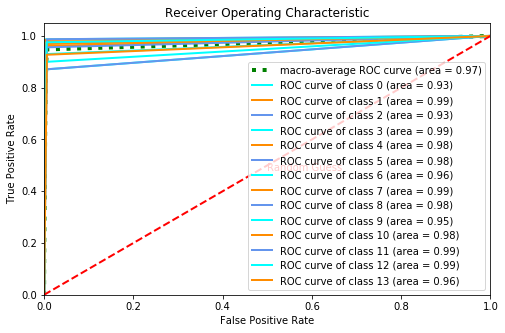

In [22]:
plot_roc(predictions)

# Linear SCV Classifier
#### Building the model

In [23]:
from sklearn.svm import LinearSVC
SVM = LinearSVC()
SVM.fit(Train_X_Tfidf,Train_Y)
predictions = SVM.predict(Test_X_Tfidf)

<h4>Accuracy of Linear SVC Model</h4>

In [24]:
print("Training Accuracy: ",Naive.score(Train_X_Tfidf,Train_Y))
print("Test Accuracy: ",Naive.score(Test_X_Tfidf,Test_Y))

Training Accuracy:  0.9530085550360373
Test Accuracy:  0.9480241061432553


<h4>Classification Report of Linear SVC Model</h4>

In [25]:
print(classification_report(Test_Y,predictions))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      2961
           1       0.97      0.98      0.98      3042
           2       0.96      0.95      0.95      2952
           3       0.98      0.99      0.99      3008
           4       0.97      0.97      0.97      3011
           5       0.98      0.99      0.98      2915
           6       0.96      0.96      0.96      3009
           7       0.99      0.99      0.99      3086
           8       0.99      0.99      0.99      2987
           9       0.96      0.97      0.97      3009
          10       0.97      0.96      0.97      3021
          11       0.99      0.99      0.99      2983
          12       0.98      0.98      0.98      3024
          13       0.96      0.97      0.97      2973

    accuracy                           0.97     41981
   macro avg       0.97      0.97      0.97     41981
weighted avg       0.97      0.97      0.97     41981



<h4>ROC Plot for Linear SVC Model</h4>

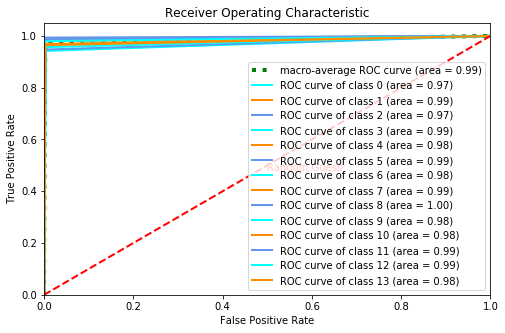

In [26]:
plot_roc(predictions)

# K Nearest Neighbours Model
#### Building the model

In [27]:
from sklearn.neighbors import KNeighborsClassifier
Knn = KNeighborsClassifier()
Knn.fit(Train_X_Tfidf,Train_Y)
predictions = Knn.predict(Test_X_Tfidf)

<h4>Accuracy of KNN Model</h4>

In [28]:
print("Training Accuracy: ",Knn.score(Train_X_Tfidf,Train_Y))
print("Test Accuracy: ",Knn.score(Test_X_Tfidf,Test_Y))

Training Accuracy:  0.9177368969107949
Test Accuracy:  0.853814820990448


<h4>Classification Report of KNN Model</h4>

In [29]:
print(classification_report(Test_Y,predictions))

              precision    recall  f1-score   support

           0       0.43      0.89      0.58      2961
           1       0.93      0.88      0.90      3042
           2       0.73      0.75      0.74      2952
           3       0.89      0.94      0.91      3008
           4       0.95      0.78      0.86      3011
           5       0.96      0.86      0.91      2915
           6       0.95      0.82      0.88      3009
           7       0.96      0.95      0.95      3086
           8       0.98      0.98      0.98      2987
           9       0.93      0.89      0.91      3009
          10       0.95      0.88      0.91      3021
          11       0.96      0.86      0.90      2983
          12       0.96      0.79      0.87      3024
          13       0.94      0.69      0.79      2973

    accuracy                           0.85     41981
   macro avg       0.89      0.85      0.86     41981
weighted avg       0.89      0.85      0.86     41981



<h4>ROC Plot for KNN Model</h4>

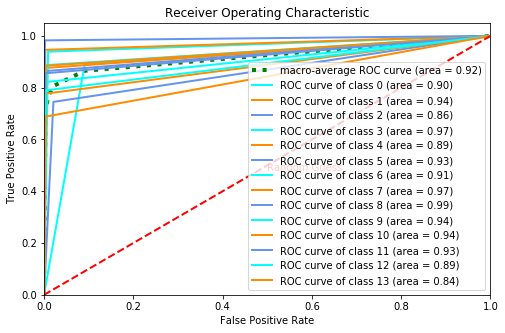

In [30]:
plot_roc(predictions)

# Random Forest Classifier
#### Building the model


In [31]:
RF=RandomForestClassifier(n_estimators=100,min_samples_split=25,max_depth=10)
RF = RF.fit(Train_X_Tfidf,Train_Y)
predictions = RF.predict(Test_X_Tfidf)

<h4>Accuracy of Random Forest Model</h4>

In [32]:
print("Training Accuracy: ",RF.score(Train_X_Tfidf,Train_Y))
print("Test Accuracy: ",RF.score(Test_X_Tfidf,Test_Y))

Training Accuracy:  0.8864160728505217
Test Accuracy:  0.8796122055215455


<h4>Classification Report of Random Forest Model</h4>

In [33]:
print(classification_report(Test_Y,predictions))

              precision    recall  f1-score   support

           0       0.75      0.75      0.75      2961
           1       0.87      0.94      0.90      3042
           2       0.88      0.68      0.77      2952
           3       0.88      0.96      0.92      3008
           4       0.92      0.88      0.90      3011
           5       0.79      0.89      0.84      2915
           6       0.92      0.77      0.84      3009
           7       0.88      0.92      0.90      3086
           8       0.98      0.98      0.98      2987
           9       0.87      0.84      0.86      3009
          10       0.87      0.86      0.86      3021
          11       0.91      0.99      0.95      2983
          12       0.93      0.96      0.94      3024
          13       0.88      0.89      0.88      2973

    accuracy                           0.88     41981
   macro avg       0.88      0.88      0.88     41981
weighted avg       0.88      0.88      0.88     41981



<h4>ROC Plot for Random Forest Model</h4>

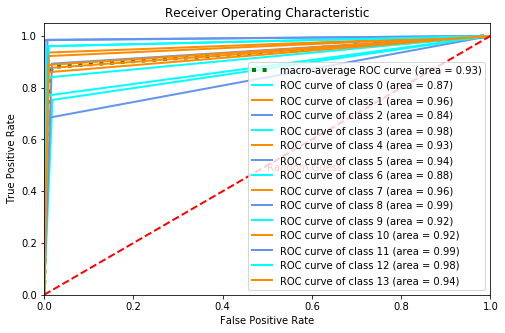

In [34]:
plot_roc(predictions)

# Final Conclusions
### KNN Model gives very less accuracy when compared to other models
### We can use Naive Bayesian Model or Linear SVC Model which gives us very good test accuracy which means it is very good at generalizing